# SafeGen 

In [1]:
import copy

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from datetime import datetime

In [2]:
import more_itertools
import ast
import pypareto

In [3]:
import pandas as pd
import numpy as np
import itertools
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from functools import partial
from statistics import mean, stdev
from sklearn.naive_bayes import GaussianNB
from math import dist
from itertools import product
from collections import Counter, OrderedDict
from sklearn.preprocessing import LabelEncoder
from statistics import mean, stdev

from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.knn import KNN


from sklearn_extra.cluster import KMedoids
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors as NN
from sklearn.ensemble import RandomForestClassifier

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None 


In [4]:
import lightgbm as ltb
from scipy.stats import chi2_contingency

In [5]:
import time
import statistics

In [6]:
from scipy.spatial import distance

In [7]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler


In [8]:
from sdv.evaluation import evaluate as eva



In [9]:
def get_encoded_cat(df, categorical_attributes, one_hot = True):
    if one_hot:    
        for attribute in categorical_attributes:  
            y = pd.get_dummies(getattr(df,attribute), prefix=attribute) 
            df = df.drop(attribute, axis = 1)
            df = pd.concat([df, y], axis = 1)
    else:
        for attribute in categorical_attributes:  
            le = preprocessing.LabelEncoder()
            le.fit(getattr(df,attribute))
            df[attribute] = le.transform(getattr(df,attribute))     
    return df

In [10]:
# functions to implement k_anonymity_categorical

def get_privacy_k_old(comb, df, k, attr):
    df_tmp = df.copy()
    for c in comb:
        for v in c:
            df_tmp[attr] = np.where(df_tmp[attr]  == v, str(c), df_tmp[attr] )
    
    groups = df_tmp.groupby(attr).size()
    groups_diff = abs(groups.min() - k)
            
    return groups_diff

def get_privacy_k(comb, df, k, attr, QI):
    df_tmp = df.copy()
    for c in comb:
        for v in c:
            df_tmp[attr] = np.where(df_tmp[attr]  == v, str(c), df_tmp[attr] )
    
    groups = df_tmp.groupby(QI).size()
    groups_diff = abs(groups.min() - k)
            
    return groups_diff

def get_accuracy(comb, df, attr, class_name, model=GaussianNB()):
    df_tmp = df.copy()
    df_tmp = get_encoded_cat(df_tmp, [attr], one_hot = False)
        
    #if k_value >= k:
    X = np.array(df_tmp[attr]).reshape(-1, 1) #.values
    y = df_tmp[class_name].to_list()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy



def get_discrimination_simple (df, attr, class_name, q_combs):
    
    comb_list = []               
               
    for comb in q_combs:
        
        record_amount = []
        for val in comb:
            PP = df[(~df[attr].isin(val)) & (df[class_name] == 1)].values.tolist()
            PN = df[(~df[attr].isin(val)) & (df[class_name] == 0)].values.tolist()
            DP = df[(df[attr].isin(val)) & (df[class_name] == 1)].values.tolist()
            DN = df[(df[attr].isin(val)) & (df[class_name] == 0)].values.tolist()

            disc = len(DN) + len(DP)
            priv = len(PN) + len(PP)
            pos = len(PP) + len(DP)
            neg = len(PN) + len(DN)

            DP_exp = round(disc * pos / len(df))
            PP_exp = round(priv * pos / len(df))
            DN_exp = round(disc * neg / len(df))
            PN_exp = round(priv * neg / len(df))

            discrimination = len(PP) / (len(PP) + len(PN)) - len(DP) / (len(DP) + len(DN))

            if discrimination >= 0:

                record_amount.append((abs(len(DP)-DP_exp) + abs(len(DN)-DN_exp)))

        global_disc = 100 * sum(record_amount) / len(df)

        comb_list.append([sum(record_amount), global_disc, comb])

    comb_list.sort(key=lambda x: x[1])
                
    return comb_list





def k_anonymity_categorical(df, QI, QI_cat, SA, class_name, k):
    QI_cat_tmp = {}
    for cat in QI_cat:
        unique_val = len(df[cat].unique())
        
        if unique_val <= 2:
            print("Due to the fact that only non-binary attributes can be generalized,", cat, "won't be generalized")
            print('')
        elif unique_val > 10:
            print("Cannot generalize the attribute", cat, ", as it would be computationally expensive. Try generalize it as a continuous attribute")
            print('')
        else:
            QI_cat_tmp[cat] = unique_val
    
    # sort the categorical attribute to generilize according to the number of distinct value: 
    # i.e.  it will be generalized first the QI having the most number of distinct value
    QI_cat_tmp = sorted(QI_cat_tmp, key=lambda x: QI_cat_tmp[x], reverse=True)
    
    
    for attr in QI_cat_tmp:
        comb_list = []
        values = list(df[attr].unique())
         
        for q in range(2, len(values)):
            n = math.ceil((len(values) / q)) 
            q_combs = [e for e in list(more_itertools.set_partitions(values, n)) if max(map(len, e)) == q]
            q_combs_final = []

            if len(values) > 3:              
                for comb in q_combs:
                    flag = True
                    for c in comb:
                        if len(c) == 1:
                            flag = False
                    if flag != False:
                        q_combs_final.append(comb)
            else:
                q_combs_final = q_combs
      
            if len(q_combs_final) > 0:               
                if attr in SA:
                    combinations_values = get_discrimination_simple(df, attr, class_name, q_combs_final)
                    combs_pareto = find_optimal_groups(df, attr, class_name, k, combinations_values, QI, fair = True)
                else:
                    combs_pareto = find_optimal_groups(df, attr, class_name, k, list(q_combs_final), QI, fair = False)              
                comb_list.append(combs_pareto[0][0])

        optimal_groups = comb_list[0]
        optimal_groups = optimal_groups[-1]
        
        groups = ast.literal_eval(optimal_groups)
        print('The attribute', attr,' will be diveded into', len(groups) ,'groups:', groups)

        for group in groups:   
            for val in group:
                df[attr] = df[attr].astype(str)
                df[attr] = np.where(df[attr] == str(val), str(group), df[attr])
        
        if get_k_anonymity(df, QI) >= k:
            return df
    return df

def find_optimal_groups(df, attr, class_name, k, combinations_values, QI, fair = True):
    
    privacy_diff = pypareto.MaxMin.MIN
    fairness = pypareto.MaxMin.MIN
    accuracy = pypareto.MaxMin.MAX
    
    for i in range(len(combinations_values)):       
        comb = combinations_values[i]
        if fair:
            comb_ = comb[2]    
        else:
            comb_ = comb
            comb = [comb]
        k = get_privacy_k(comb_, df, k, attr,QI)
        acc = get_accuracy(comb_, df, attr, class_name)
        comb.insert(0, k)
        comb.insert(0, acc)
        comb[len(comb)-1] = str(comb[len(comb)-1]) 
        combinations_values[i] = tuple(comb)
    values = combinations_values
    if fair:
        chain = pypareto.Comparison(pypareto.by_value, pypareto.MaxMinList(privacy_diff, fairness, accuracy)).as_chain()
    else:
        chain = pypareto.Comparison(pypareto.by_value, pypareto.MaxMinList(privacy_diff, accuracy)).as_chain()
    combs_pareto = chain.split_by_pareto(values)
    return combs_pareto

In [11]:
def find_optimal_ranges(df, attr, QI, QI_cont, k, class_name, model=GaussianNB()):
    '''Finds the optimal number of ranges for a continuous attribute while considering accuracy impact
    df: dataframe
    QI: quasi-identifiers
    attr: current attribute
    QI_cont:  continuous quasi identifiers to be generalized
    k: desired k-anonymity level
    model: the classifier to use for accuracy calculation
    y: target labels'''
    
    ranges_dict = {}
    accuracy_dict = {}
    ranges = 2   
    
    while True: 
        df_tmp = df.copy()
        df_tmp[attr] = pd.cut(df_tmp[attr], ranges)
        k_value = get_k_anonymity(df_tmp, QI)
        ranges_dict[ranges] = k_value 
        df_tmp = get_encoded_cat(df_tmp, [attr], one_hot = False)
        
        #if k_value >= k:
        X = df_tmp[QI_cont] #.values
        y = df_tmp[class_name].to_list()
        
        
        X_train, X_test, y_train, y_test = train_test_split(df_tmp[QI_cont], y, test_size=0.2, random_state=0)      
        model.fit(X_train, y_train)   
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_dict[ranges] = accuracy
        
        ranges += 1
        if k_value < k:
            break
            
    # Find the range that gives the best compromise between k-anonymity and accuracy
    best_range = 0
    best_accuracy = 0
    best_k = float('-inf')
    for i in ranges_dict.keys():
        if abs(ranges_dict[i] - k) <= abs(best_k - k) and accuracy_dict[i] >= best_accuracy:
            best_range = i
            best_k = ranges_dict[i]
            best_accuracy = accuracy_dict[i]
    return best_range

def k_anonymity_with_accuracy(df, QI, QI_cont, k, class_name):
    '''Generalize continuous attributes by ranges the values according to a desired k '''
    
    for attr in QI_cont:
        ranges = find_optimal_ranges(df, attr, QI, QI_cont, k, class_name)   
        
        print('The attribute', attr,' will be diveded into', ranges,'ranges')
        df[attr] = pd.cut(df[attr], ranges)
        
        df = get_encoded_cat(df, [attr], one_hot = False)
        
        if get_k_anonymity(df, QI) >= k:
            return df
        
    return df

In [12]:
def suppress_records(df, QI, k):
    df_tmp = df.copy()
    df_tmp = df_tmp.reset_index()
    df_tmp['Count'] = 0
    
    # getting the minimum number of records for each combination: 10 % of k 
    freq_t = (10 * k)/100 
    
    unique_comb = df_tmp.groupby(QI).agg({'Count': 'count', 'index': list}).reset_index()
    unique_comb = unique_comb.drop(unique_comb[unique_comb.Count == 0].index)
    
    # evalutating freq: suppressing equivalence classes with size less than freq_t
    unque_comb_drop = unique_comb[unique_comb.Count < freq_t]
    
    for irex ,frow in unque_comb_drop.iterrows():
        index_list = frow['index']

        dict_val = frow.to_dict()
        dict_val.pop('index', None)
        dict_val.pop('Count', None)

        df.loc[index_list,list(dict_val.keys())] = list(dict_val.values())

    index_list_all = [y for x in unque_comb_drop['index'].tolist() for y in x]

    df.drop(index_list_all, inplace = True)
    
    print('Supressing', len(index_list_all),'records with freq <',freq_t, '\n')
    
    unique_comb = unique_comb.drop(unique_comb[unique_comb.Count < freq_t].index)
    return df

In [13]:
def merge_dictionary(dict_1, dict_2):
    result = {**dict_1, **dict_2}
    for key, value in result.items():
        if key in dict_1 and key in dict_2:
               result[key] = dict_1[key] + dict_2[key]
    return result

In [14]:
def get_anonymity_combinations(df, QI):
    df_tmp = df.reset_index()
    df_tmp['Count'] = 0

    unique_comb = df_tmp.groupby(QI).agg({'Count': 'count', 'index': list}).reset_index()
    unique_comb = unique_comb.drop(unique_comb[unique_comb.Count == 0].index)
    return unique_comb

In [15]:
def get_k_anonymity(df, QI):
    df_tmp = df.reset_index()
    df_tmp['Count'] = 0

    unique_comb = df_tmp.groupby(QI).agg({'Count': 'count', 'index': list}).reset_index()
    unique_comb = unique_comb.drop(unique_comb[unique_comb.Count == 0].index)
    k_min = min(unique_comb.Count)
    return k_min

In [16]:
def ranker(df, attributes, class_name, quasi_identifiers):
    ''' It computes the  prediticive probability and the  normalized k for each record'''
    X = df[attributes].values
    
    
    y = df[class_name].to_list()
    clf = GaussianNB()

    clf.fit(X, y)
    X_proba = [None] * len(X)
    probability = []
    for k in range(len(X)):
        X_proba[k] = np.append(X[k], (y[k], clf.predict_proba(X)[k][1]))
           
    X_proba = np.array(X_proba, dtype=float).tolist()
    
    X_proba_list = []
    
    for arr in (X_proba):
        X_proba_list.append(arr[:len(attributes)+2])
        
    X_proba = pd.DataFrame.from_records(X_proba_list)
    X_proba.columns = attributes + [class_name] + ['proba']
    
    # get k value for each record, k_normalized, proba + k
    df_tmp = X_proba.reset_index()
    df_tmp['Count'] = 0
    
    unique_comb = df_tmp.groupby(quasi_identifiers).agg({'Count': 'count', 'index': list}).reset_index()
    unique_comb = unique_comb.drop(unique_comb[unique_comb.Count == 0].index)
    X_proba['k'] = [None] * len(X)
    
    # for each record we save the corresponding k value of k-anonymity
    for row , row1 in zip(unique_comb['index'], unique_comb['Count']): # per ciascun gruppo
        partition = X_proba.iloc[row] # partizione
        X_proba.loc[row,['k']] = row1
    
    # normalize the k-value to 0-1 range: per k alti verrà assegnato valori più vicini allo
    scaler = MinMaxScaler()
    X_proba['k_norm'] = scaler.fit_transform(np.array(X_proba['k']).reshape(-1, 1))
    
    # get the score as probability of Naive Baies + k_norm    
    # adding k_norm (DN,PN) o subtracting (DP e PP)
    X_proba['(proba+k)'] = X_proba['proba'] + X_proba['k_norm'] #(DN,PN)  # sorted  in descending order
    X_proba['(proba-k)'] = X_proba['proba'] - X_proba['k_norm'] # (DP e PP) # sorted in ascending order
      
    return X_proba

In [17]:
def get_index (df, attribute, attributes):
    for i in range(len(attributes)):
        if attributes[i] == attribute:
            return i

In [18]:
def get_closest_value (val, value_list):
    
    return value_list[np.argmin(np.abs(np.array(value_list)-val))]

In [19]:
def get_causal_regressor (data, index_X, index_y):
    
    X = data.iloc[:, index_X].values
    y = data.iloc[:, [index_y]].values

    regr = ltb.LGBMRegressor().fit(X, y)

    return regr

In [20]:
def get_causal_classifier (data, index_X, index_y):

    X = data.iloc[:, index_X].values
    y = data.iloc[:, [index_y]].values

    classifier = ltb.LGBMClassifier().fit(X, y)    

    return classifier

In [21]:
def get_discrimination_float (df, sensitive_attributes, class_name):

# ASSUMPTION: Each value of the attribute is discriminated
# For each value, we therefore apply the Preferential Sampling formulas to compute the discrimination 
# If discrimination > 0, the assumption holds true
# Otherwhise, it doesn't. This means the value is actually *privileged*
# A dictionary of sensitive attributes and values is created as such
#
# Please note the sum of records to add / remove for each priviliged value
# should be equal to the sum of records to add / removed for each discriminated value
#
# A rounding error is possible

    
    sensitive_dict = {}
    
    tot_disc = 0
    tot_pos = 0
    
    #df = X_proba
    
    for attr in sensitive_attributes:
        sensitive_dict[attr] = {}
        sensitive_dict[attr]['D'] = {}
        sensitive_dict[attr]['P'] = {}
        sensitive_dict[attr]['D']['values_list'] = []
        sensitive_dict[attr]['P']['values_list'] = []
        values = df[attr].unique()
        for val in values:
            PP = df[(df[attr] != val) & (df[class_name] == 1)].values.tolist()
            PN = df[(df[attr] != val) & (df[class_name] == 0)].values.tolist()
            DP = df[(df[attr] == val) & (df[class_name] == 1)].values.tolist()
            DN = df[(df[attr] == val) & (df[class_name] == 0)].values.tolist()

            disc = len(DN) + len(DP)
            priv = len(PN) + len(PP)
            pos = len(PP) + len(DP)
            neg = len(PN) + len(DN)
            
            DP_exp = disc * pos / len(df)
            PP_exp = priv * pos / len(df)
            DN_exp = disc * neg / len(df)
            PN_exp = priv * neg / len(df)
            
            discrimination = len(PP) / (len(PP) + len(PN)) - len(DP) / (len(DP) + len(DN))
       
            if discrimination >= 0:
                status = 'D'
                sensitive_dict[attr][status][val] = {}             
                sensitive_dict[attr][status][val]['P_exp'] = DP_exp                            
                sensitive_dict[attr][status][val]['N_exp'] = DN_exp
                
            else:
                status = 'P'
                sensitive_dict[attr][status][val] = {}  
                
                # ordinati sulla base della vicinanza alla decision boundary
                sensitive_dict[attr][status][val]['P_exp'] = DP_exp
                sensitive_dict[attr][status][val]['N_exp'] = DN_exp           
            sensitive_dict[attr][status]['values_list'].append(val)
        
                                   
    return sensitive_dict  

In [22]:
def get_discrimination (df, sensitive_attributes, class_name):

# ASSUMPTION: Each value of the attribute is discriminated
# For each value, we therefore apply the Preferential Sampling formulas to compute the discrimination 
# If discrimination > 0, the assumption holds true
# Otherwhise, it doesn't. This means the value is actually *privileged*
# A dictionary of sensitive attributes and values is created as such
#
# Please note the sum of records to add / remove for each priviliged value
# should be equal to the sum of records to add / removed for each discriminated value
#
# A rounding error is possible

    
    sensitive_dict = {}
    
    tot_disc = 0
    tot_pos = 0
    
    #df = X_proba
    
    for attr in sensitive_attributes:
        print ()
        print ("Analizing", attr, "...")
        sensitive_dict[attr] = {}
        sensitive_dict[attr]['D'] = {}
        sensitive_dict[attr]['P'] = {}
        sensitive_dict[attr]['D']['values_list'] = []
        sensitive_dict[attr]['P']['values_list'] = []
        values = df[attr].unique()
        for val in values:
            PP = df[(df[attr] != val) & (df[class_name] == 1)].values.tolist()
            PN = df[(df[attr] != val) & (df[class_name] == 0)].values.tolist()
            DP = df[(df[attr] == val) & (df[class_name] == 1)].values.tolist()
            DN = df[(df[attr] == val) & (df[class_name] == 0)].values.tolist()

            disc = len(DN) + len(DP)
            priv = len(PN) + len(PP)
            pos = len(PP) + len(DP)
            neg = len(PN) + len(DN)
            
            DP_exp = round(disc * pos / len(df))
            PP_exp = round(priv * pos / len(df))
            DN_exp = round(disc * neg / len(df))
            PN_exp = round(priv * neg / len(df))
            
            discrimination = len(PP) / (len(PP) + len(PN)) - len(DP) / (len(DP) + len(DN))
       
            if discrimination >= 0:
                status = 'D'
                sensitive_dict[attr][status][val] = {}
                print("")
                print(val, "is discriminated:", discrimination)
                
                sensitive_dict[attr][status][val]['P'] = sorted(DP, key=lambda x:x[len(DP[0])-1]) # sottraendo (DP e PP)
                sensitive_dict[attr][status][val]['P_exp'] = DP_exp
                sensitive_dict[attr][status][val]['P_curr'] = 0
                
                for i in range(len(sensitive_dict[attr][status][val]['P'])):
                    ### Aggiunto: per ciascun record si eliminano le ultime 5 colonne corrispondenti a proba, k, k_normalized, proba + k, proba - k
                    for j in range(5):
                        del sensitive_dict[attr][status][val]['P'][i][-1]
                    
                                
                sensitive_dict[attr][status][val]['N'] = sorted(DN, key=lambda x:x[len(DN[0])-2], reverse = True)  # aggiundendo (DN e PN)
                sensitive_dict[attr][status][val]['N_exp'] = DN_exp
                sensitive_dict[attr][status][val]['N_curr'] = 0

                for i in range(len(sensitive_dict[attr][status][val]['N'])):
                    ### Aggiunto: per ciascun record si eliminano le ultime 5 colonne corrispondenti a proba, k, k_normalized, proba + k, proba - k
                    for j in range(5):
                        del sensitive_dict[attr][status][val]['N'][i][-1]
                    
                print("- DP:", len(sensitive_dict[attr][status][val]['P']), '· Expected:', DP_exp, 
                      '· To be added:', abs(len(DP) - DP_exp))
                print("- DN:", len(sensitive_dict[attr][status][val]['N']), '· Expected:', DN_exp, 
                      '· To be removed:', abs(len(DN) - DN_exp))
                
                tot_disc = tot_disc + abs(len(DP) - DP_exp)
                
            else:
                status = 'P'
                sensitive_dict[attr][status][val] = {}
                print("")
                print(val, "is privileged:", discrimination)   
                
                # ordinati sulla base della vicinanza alla decision boundary
                
                sensitive_dict[attr][status][val]['P'] = sorted(DP, key=lambda x:x[len(DP[0])-1])
                sensitive_dict[attr][status][val]['P_exp'] = DP_exp
                sensitive_dict[attr][status][val]['P_curr'] = 0

                for i in range(len(sensitive_dict[attr][status][val]['P'])):
                    ### Aggiunto: per ciascun record si eliminano le ultime 4 colonne corrispondenti a proba, k, k_normalized, proba + k
                    for j in range(5):
                        del sensitive_dict[attr][status][val]['P'][i][-1]
                
                
                sensitive_dict[attr][status][val]['N'] = sorted(DN, key=lambda x:x[len(DN[0])-2], reverse = True)
                sensitive_dict[attr][status][val]['N_exp'] = DN_exp
                sensitive_dict[attr][status][val]['N_curr'] = 0

                for i in range(len(sensitive_dict[attr][status][val]['N'])):
                    ### Aggiunto: per ciascun record si eliminano le ultime 5 colonne corrispondenti a proba, k, k_normalized, proba + k,proba - k
                    for j in range(5):
                        del sensitive_dict[attr][status][val]['N'][i][-1]
                
                print("- PP:", len(sensitive_dict[attr][status][val]['P']), '· Expected:', DP_exp, 
                      '· To be removed:', abs(len(DP) - DP_exp))
                print("- PN:", len(sensitive_dict[attr][status][val]['N']), '· Expected:', DN_exp, 
                      '· To be added:', abs(len(DN) - DN_exp))
                
                tot_pos = tot_pos + abs(len(DP) - DP_exp)
            
            sensitive_dict[attr][status]['values_list'].append(val)
        
    round_error = abs(tot_disc - tot_pos)
    
    if round_error > 0:
        print ("")
        print ("Due to a rounding error, the final dataset might be slightly smaller")
                                  
    return sensitive_dict  

In [23]:
def random_individual(values, const, 
                      values_in_dataset_indexes, discrete_indexes, regular_indexes, 
                      causal_reg, causal_class, ds):
    
    df = pd.DataFrame(values)
    
    ind = [None] * (len(df.columns)-1)
        
    for i in regular_indexes:
        val = df.iloc[:, i].to_list()
        
        if i in values_in_dataset_indexes: #if the feat can only assume values already in the dataset
            if ds == 'Random': #if values are picked randomly
                ind[i] = random.choice(list(set(val)))
            elif ds == 'Fixed': #if values are picked w.r.t. their frequency
                ind[i] = random.choice(val)
        elif i in discrete_indexes: #if the feat can only assume a random value in a int range
            ind[i] = random.randint(min(val), max(val))            
        else: #if the feat can assume a float value in a range
            ind[i] = random.uniform(min(val), max(val))
            
    for tup in const:
        ind[tup[0]] = tup[1]
    
    for e in causal_reg + causal_class:
        
        X_indexes = e[0]
        y = e[1]
        pred = e[2]
        
        X_val = []
        for index in X_indexes:
            X_val.append(ind[index])
             
        predicted = pred.predict([X_val])
        
        if y in values_in_dataset_indexes:
            value_list = df.iloc[:, y].to_list()
            ind[y] = get_closest_value(predicted[0], value_list)        
        elif y in discrete_indexes:
            ind[y] = int(predicted[0])        
        else: 
            ind[y] = predicted[0]
    
    return ind

In [24]:
def evaluate(individual, forest, medoid,  mode, scaler): #k
 
    #individual = individual[0]
    
    # NORM
    individual = np.array(individual[0])
    
    individual = scaler.transform(individual.reshape(1, -1))[0]
    #print (medoid)
    #print ("IND:", individual)
    if mode == "Outlier":
        score = float(forest.predict_proba(np.array([individual]))[0][1])

    elif mode == "Distance":
        if None in medoid:
            score = float(forest.predict_proba(np.array([individual]))[0][1])

        else:
            score = distance.cosine(individual, medoid) / 2            
                   
    elif mode == 'Hybrid':
        score = float(forest.predict_proba(np.array([individual]))[0][1])

        if None not in medoid:
            score = (score + distance.cosine(individual, medoid) / 2) / 2

        
    return score,

In [25]:
def mate(ind1, ind2, values, 
         values_in_dataset_indexes, discrete_indexes, regular_indexes, 
         causal_reg, causal_class):
    
    #custom crossover
    
    indpb = 0.34
    
    for i in regular_indexes:
        if random.random() < indpb:
            ind1[i], ind2[i] = ind2[i], ind1[i]
            for e in causal_reg + causal_class:
                if i in e[0]:
                    df = pd.DataFrame(values)
                    
                    X_indexes = e[0]
                    y = e[1]
                    pred = e[2]

                    X_val1 = []
                    X_val2 = []
                    for index in X_indexes:
                        X_val1.append(ind1[index])
                        X_val2.append(ind2[index])

                    #ind1
                    predicted1 = pred.predict([X_val1])

                    if y in values_in_dataset_indexes:
                        value_list = df.iloc[:, y].to_list()
                        ind1[y] = get_closest_value(predicted1[0], value_list)        
                    elif y in discrete_indexes:
                        ind1[y] = int(predicted1[0])        
                    else: 
                        ind1[y] = predicted1[0]
                        
                    #ind2
                    predicted2 = pred.predict([X_val2])

                    if y in values_in_dataset_indexes:
                        value_list = df.iloc[:, y].to_list()
                        ind2[y] = get_closest_value(predicted2[0], value_list)        
                    elif y in discrete_indexes:
                        ind2[y] = int(predicted2[0])        
                    else: 
                        ind2[y] = predicted2[0]
                        
                    
                    #print ("CHILD1:", ind1)
                    #print ("X:", X_indexes, X_val1, "y:", y, predicted1, predicted1[0][0], ind1[y])
                    #print ("CHILD2:", ind2)
                    #print ("X:", X_indexes, X_val2, "y:", y, predicted2, predicted2[0][0], ind2[y])                    
                
    return ind1, ind2

In [26]:
def mutate(individual, values, 
           values_in_dataset_indexes, discrete_indexes, regular_indexes, 
           causal_reg, causal_class, ds):
    
#custom mutation

    df = pd.DataFrame(values)
    
    i = random.choice(regular_indexes) #we select a random feature to mutate
    

    if i in values_in_dataset_indexes: 
        val = df.iloc[:, i].to_list()
        
        #val = [x for x in df.iloc[:, i].to_list() if x != individual[i]]
        
        if ds == "Random":
            individual[i] = random.choice(list(set(val)))
        elif ds == "Fixed":
            individual[i] = random.choice(val)
    elif i in discrete_indexes: #if the feat can only assume a random value in a int range
        val = [x for x in df.iloc[:, i].to_list() if x != individual[i]]
        individual[i] = random.randint(min(val), max(val))                        
    else: #if the feat can assume a float value in a range
        val = [x for x in df.iloc[:, i].to_list() if x != individual[i]]
        individual[i] = random.uniform(min(val), max(val))

    
    for e in causal_reg + causal_class: 
        if i in e[0]:
            #print ("Independent value mutated...")

            X_indexes = e[0]
            y = e[1]
            pred = e[2]

            X_val = []
            for index in X_indexes:
                X_val.append(individual[index])

            predicted = pred.predict([X_val])

            if y in values_in_dataset_indexes:
                value_list = df.iloc[:, y].to_list()
                individual[y] = get_closest_value(predicted[0], value_list)        
            elif y in discrete_indexes:
                individual[y] = int(predicted[0])        
            else: 
                individual[y] = predicted[0]
            
            #print ("X:", X_indexes, X_val, "y:", y, predicted, predicted[0][0], individual[y])    

    #print ("NEW MUTATED:", individual)

    return individual,

In [27]:
def GA(values, const, n_HOF, forest, medoid, # k,
       values_in_dataset_indexes, discrete_indexes, regular_indexes, 
       causal_reg, causal_class, mode, ds, scaler):
    
    check = True
    gen = 1
    
    NUM_GENERATIONS = 50
    POPULATION_SIZE = 150
    
    CXPB, MUTPB = 0.5, 0.15
    
    creator.create('Fitness', base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.Fitness)

    toolbox = base.Toolbox()

    toolbox.register("random_individual", random_individual, values, const, values_in_dataset_indexes, 
                     discrete_indexes, regular_indexes, causal_reg, causal_class, ds=ds)

    toolbox.register("individual", tools.initRepeat, creator.Individual, 
                     toolbox.random_individual, n=1)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate, forest=forest, medoid=medoid,  mode=mode, scaler = scaler)#k=k
        
    toolbox.register("mate", mate, values=values, values_in_dataset_indexes=values_in_dataset_indexes, 
                     discrete_indexes=discrete_indexes, regular_indexes=regular_indexes, 
                     causal_reg=causal_reg, causal_class=causal_class)
    
    toolbox.register("mutate", mutate, values=values, values_in_dataset_indexes=values_in_dataset_indexes, 
                     discrete_indexes=discrete_indexes, regular_indexes=regular_indexes, 
                     causal_reg=causal_reg, causal_class=causal_class, ds=ds)    
    
    toolbox.register("select", tools.selNSGA2)



    pop = toolbox.population(n=POPULATION_SIZE)

    hof = tools.HallOfFame(n_HOF)
    
    #hof = tools.ParetoFront()
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)   
    #stats.register('max', np.max, axis = 0)
    stats.register('min', np.min) #, axis = 0)
    stats.register('avg', np.mean) #, axis = 0)
    
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + stats.fields
    
    invalid_individuals = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_individuals)
    for ind, fit in zip(invalid_individuals, fitnesses):
        ind.fitness.values = fit
        
    hof.update(pop)
    hof_size = len(hof.items)

    record = stats.compile(pop)
    logbook.record(gen=0, best="-", nevals=len(invalid_individuals), **record)
    print(logbook.stream)

    while check:  
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        
        
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1[0], child2[0])
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant[0])
                del mutant.fitness.values
            
                
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
    
        # Update the hall of fame with the generated individuals
        hof.update(offspring)
        
        # Replace the current population by the offspring
        pop[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(pop) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(logbook.stream)
        
        gen = gen + 1
        if gen >= NUM_GENERATIONS + 1:         
            hof.update(pop)
            
            if len(hof) == n_HOF:
                check = False
    #hof.update(pop)
    
    counter = 0
    for e in hof.items:
        counter = counter + 1
        print("")
        print("#"+str(counter))
        print("Constraints:", const)
        print('Individual:', e)
        print('Fitness:', e.fitness)


    plt.figure(1)

    # plot genetic flow statistics:
    #maxFitnessValues, minFitnessValues, meanFitnessValues = logbook.select("max", "min", "avg")
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    plt.figure(2)
    sns.set_style("whitegrid")
    #plt.plot(maxFitnessValues, color='red')
    plt.plot(minFitnessValues, color='blue')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Value')
    plt.title('Avg and Min Fitness')
    # show both plots:
    plt.show()
    
    
    return hof.items

In [29]:
def most_frequent_combination_with_condition(df, columns, condition_columns, condition_values):

    filtered_df = df.copy()
    for col, val in zip(condition_columns,condition_values):
        filtered_df_tmp = filtered_df[filtered_df.iloc[:, [col]].isin([val]).all(axis=1)]
        if not filtered_df_tmp.empty:
            filtered_df = filtered_df_tmp.copy()

    # apply the most_frequent_combination function
    relative_frequency, combination_list = most_frequent_combination(filtered_df, columns) 
    
    return relative_frequency, combination_list 


In [30]:
def most_frequent_combination(df, columns):
    # create a new column 'combination' that concatenates the values of the specified columns
    df['combination'] = df[columns].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
    
    # use the Counter class to count the occurrences of each combination
    combination_counts = Counter(df['combination'])
    
    # find the most common combination
    most_frequent = combination_counts.most_common(1)[0]
    
    # calculate the relative frequency
    total_rows = len(df)
    relative_frequency = most_frequent[1]/total_rows
    
    # create a list of tuples containing the index of the original dataset and the corresponding value
    combination_list = []
    for i, value in enumerate(most_frequent[0].split("-")):
        col_index = columns[i]
        col_index = df.columns.get_loc(col_index)
        combination_list.append((col_index, float(value)))
    
    # return relative frequency and combination_list
    return relative_frequency, tuple(combination_list)  


In [31]:
def get_hybrid_constraints(df, constraints_privacy, constraints, sensitive_attributes, class_name):
    '''get hybrid constraints (== (QI attributes + SA attributes) as well as pure fairness constraints (SA attributes)'''
    
    hybrid_constraints = Counter()
    
    for const in constraints_privacy.keys():

        while constraints_privacy[const] > 0 and len(constraints.keys()) != 0:
            
            # get the number of records needed for privacy constraint
            n_records = constraints_privacy[const]
            
            # get the attributes combination and the respective values of privacy anf fairness constraints          
            QI_columns = [x[0] for x in const]
            QI_values = [x[1] for x in const]                   
            #SA_values = [x[1] for const in constraints for x in const]
            SA_columns = [class_name]+sensitive_attributes
            SA_index = [df.columns.get_loc(column) for column in sensitive_attributes]
            
            # find the most common combination of fairness attributes that include also the privacy constraint and the respective relative frequency
            #filtered_df = df[df.iloc[:, SA_index].isin(SA_values).all(axis=1)]  
               
            flag = False
            # filter the dataset with sensitive values + class target
            mask = df.apply(lambda row: any(all(row.iloc[attr] == value for attr, value in combination) for combination in constraints.keys()), axis=1)
            filtered_df = df[mask]
            
            # checking wheter the the dataset is empty, if so filter the dataset with only the sensitive values
            if filtered_df.empty:
                flag = True
                SA_columns = sensitive_attributes              
                mask = df.apply(lambda row: any(all(row.iloc[attr] == value for attr, value in combination if attr in SA_index) for combination in constraints.keys()), axis=1)
                filtered_df = df[mask]
            
            
            # getting the most frequent tuples and frequency
            relative_frequency, tuple_most_freq = most_frequent_combination_with_condition(filtered_df, SA_columns , QI_columns, QI_values)                
            
            # if we filtered the dataset with only sensitive values, find also the right target value
            if flag: 
                first_tuples = [key[0] for key in constraints.keys()]
                for i in range(len(first_tuples)):
                    tuple_most_freq_tmp = ((first_tuples[i]),) + tuple_most_freq
                    if tuple_most_freq_tmp in constraints.keys():
                        tuple_most_freq  = tuple_most_freq_tmp
                        break
            
            
            # calculate the number of records to be added wrt this combination according to the relative frequency
            records_to_add = math.ceil(relative_frequency * n_records)

            # check if it's greater than the n° of records available in the fairness combination 
            if records_to_add > constraints[tuple_most_freq]:
                records_to_add = constraints[tuple_most_freq]  
          
            # append the fairness constraint + privacy constraint to the list of hybrid constraints
                   
            # update the n° of records needed/available for/in the privacy/fairness constraints
            substract_records = constraints[tuple_most_freq] - records_to_add
          
            
            # create a set of the first elements in the second tuple
            set_of_first_elements = set(item[0] for item in const)

            # loop through the first tuple and add each element to the second tuple
            result = ()
            for item in tuple_most_freq:
                if item[0] not in set_of_first_elements:
                    result += (item,)
            result += const
                     
                        
            if  substract_records <= 0:
                
                constraints_privacy[const] = constraints_privacy[const] - constraints[tuple_most_freq]
                hybrid_constraints[(tuple(result))] = hybrid_constraints[(tuple(result))] + constraints[tuple_most_freq]
                
                constraints.pop(tuple_most_freq)
            else:
               
                constraints[tuple_most_freq] = substract_records
                constraints_privacy[const] = constraints_privacy[const] - records_to_add
                
                
                hybrid_constraints[(tuple(result))] = hybrid_constraints[(tuple(result))] + records_to_add
                
    for const, value in list(constraints.items()):
        if value == 0:
            constraints.pop(const)
            
    print('New hybrid constraints created:', hybrid_constraints)      
    constraints = {k: v for k, v in constraints.items() if v != 0}
    hybrid_constraints.update(constraints)
    
    return hybrid_constraints


In [32]:
def get_distribution(df, sensitive_dict, n_records, sensitive_attributes, privacy_combs = [], target_distr = False):
    dict_distr = {}
    for attr in sensitive_dict: 
        dict_distr[attr] = {}
        dict_distr[attr]['D'] = {}
        dict_distr[attr]['P'] = {}

        dict_distr[attr]['D']['values_list'] = sensitive_dict[attr]['D']['values_list']
        dict_distr[attr]['P']['values_list'] = sensitive_dict[attr]['P']['values_list']


        for val in sensitive_dict[attr]['D']['values_list']:
            dict_distr[attr]['D'][val] = {}
            dict_distr[attr]['D'][val]['P_curr'] = 0
            dict_distr[attr]['D'][val]['N_curr'] = 0
            dict_distr[attr]['D'][val]['P_exp'] = 0
            dict_distr[attr]['D'][val]['N_exp'] = 0 
            if target_distr == False:
                len_ = len(df)
                dict_distr[attr]['D'][val]['P_exp'] = round(n_records*(sensitive_dict[attr]['D'][val]['P_exp']/len_))
                dict_distr[attr]['D'][val]['N_exp'] = round(n_records*(sensitive_dict[attr]['D'][val]['N_exp']/len_))


        for val in sensitive_dict[attr]['P']['values_list']:
            dict_distr[attr]['P'][val] = {}
            dict_distr[attr]['P'][val]['P_curr'] = 0
            dict_distr[attr]['P'][val]['N_curr'] = 0
            dict_distr[attr]['P'][val]['P_exp'] = 0
            dict_distr[attr]['P'][val]['N_exp'] = 0 
            if target_distr == False:
                len_ = len(df)
                dict_distr[attr]['P'][val]['P_exp'] = round(n_records*(sensitive_dict[attr]['P'][val]['P_exp']/len_))
                dict_distr[attr]['P'][val]['N_exp'] = round(n_records*(sensitive_dict[attr]['P'][val]['N_exp']/len_)) 
    
    if target_distr:
        
        for comb in privacy_combs:
            for i in range(len(comb)):
                if isinstance(comb[i], tuple): 
                    pass         
                else:
                    attr = sensitive_attributes[i]
                    val = comb[i]
                    n_rec = privacy_combs[comb]

                    if val in dict_distr[attr]['P']['values_list']:
                        len_ = sensitive_dict[attr]['P'][val]['P_exp'] + sensitive_dict[attr]['P'][val]['N_exp']

                        dict_distr[attr]['P'][val]['P_exp'] = dict_distr[attr]['P'][val]['P_exp'] + round(n_rec * (sensitive_dict[attr]['P'][val]['P_exp']/ len_))
                        dict_distr[attr]['P'][val]['N_exp'] = dict_distr[attr]['P'][val]['N_exp'] + round(n_rec * (sensitive_dict[attr]['P'][val]['N_exp']/ len_))
                    if val in dict_distr[attr]['D']['values_list']:
                        len_ = sensitive_dict[attr]['D'][val]['P_exp'] + sensitive_dict[attr]['D'][val]['N_exp']

                        dict_distr[attr]['D'][val]['P_exp'] = dict_distr[attr]['D'][val]['P_exp'] + round(n_rec * (sensitive_dict[attr]['D'][val]['P_exp']/ len_))
                        dict_distr[attr]['D'][val]['N_exp'] = dict_distr[attr]['D'][val]['N_exp'] + round(n_rec * (sensitive_dict[attr]['D'][val]['N_exp']/ len_))                 
            
    return dict_distr

In [33]:
def get_constraints_with_conditions(df, privacy_combs, sensitive_dict, attributes, sensitive_attributes):
    constraints = []
    
    for comb in privacy_combs:
        
        
        while privacy_combs[comb] > 0 and True:
            QI_tup = []
            starting_const_len = len(constraints)
            check = True
            ok_comb_neg = True
            ok_comb_pos = True
            constraint_neg = [(len(attributes), 0)]
            constraint_pos = [(len(attributes), 1)]
            
            
            for i in range(len(comb)):
                if isinstance(comb[i], tuple):
                    QI_tup.append(comb[i])         
                else:
                    att = sensitive_attributes[i]
                    val = comb[i]

                    if val in sensitive_dict[att]['D']['values_list']:
                        if sensitive_dict[att]['D'][val]['N_curr'] < sensitive_dict[att]['D'][val]['N_exp']:
                            constraint_neg.append((get_index(df, att, attributes), val))              

                        else:
                            ok_comb_neg = False 
                    elif val in sensitive_dict[att]['P']['values_list']:
                        if sensitive_dict[att]['P'][val]['N_curr'] < sensitive_dict[att]['P'][val]['N_exp']:
                            constraint_neg.append((get_index(df, att, attributes), val))

                        else:
                            ok_comb_neg = False

                    if val in sensitive_dict[att]['D']['values_list']:
                        if sensitive_dict[att]['D'][val]['P_curr'] < sensitive_dict[att]['D'][val]['P_exp']:
                            constraint_pos.append((get_index(df, att, attributes), val))

                        else:
                            ok_comb_pos = False                        
                    elif val in sensitive_dict[att]['P']['values_list']:
                        if sensitive_dict[att]['P'][val]['P_curr'] < sensitive_dict[att]['P'][val]['P_exp']:
                            constraint_pos.append((get_index(df, att, attributes), val))

                        else:
                            ok_comb_pos = False   

            if ok_comb_neg == True:          
                for tup in constraint_neg[1:]:
                    att = attributes[tup[0]]
                    val = tup[1]
                    if val in sensitive_dict[att]['D']['values_list']:
                        sensitive_dict[att]['D'][val]['N_curr'] = sensitive_dict[att]['D'][val]['N_curr'] + 1
                    elif val in sensitive_dict[att]['P']['values_list']:
                        sensitive_dict[att]['P'][val]['N_curr'] = sensitive_dict[att]['P'][val]['N_curr'] + 1
                
                constraints.append(tuple(constraint_neg + QI_tup))
                privacy_combs[comb] = privacy_combs[comb] - 1
                
            if ok_comb_pos == True:     
                for tup in constraint_pos[1:]:
                    att = attributes[tup[0]]
                    val = tup[1]
                    if val in sensitive_dict[att]['D']['values_list']:
                        sensitive_dict[att]['D'][val]['P_curr'] = sensitive_dict[att]['D'][val]['P_curr'] + 1
                    elif val in sensitive_dict[att]['P']['values_list']:
                        sensitive_dict[att]['P'][val]['P_curr'] = sensitive_dict[att]['P'][val]['P_curr'] + 1
                
                constraints.append(tuple(constraint_pos + QI_tup))
                privacy_combs[comb] = privacy_combs[comb] - 1
                
            if ok_comb_neg == False and ok_comb_pos == False:
                break
                

            if len(constraints) == starting_const_len:
                break
                
                
    constraints = Counter(tuple(constraints))
    return constraints, sensitive_dict

In [34]:
def get_constraints(df, attributes, common_combs, sensitive_dict, quasi_identifiers, sensitive_attributes):
    ### Aggiunto constraint per memorizzare le combinazioni senza distinzione tra positivo e negativo !(solo attributi presenti in QI)!
    constraints_gen = []
    ##   
    constraints = []
    # a constraint is a binary tuple
    # tuple[0] = index of a feature; tuple[1] = value of the feature
    # we'll make a constraint for the sensitive attribute(s) and the target variable
           
            
    # combinations of sensitive attributes values are ordered according to their frequency in common_combs
    # higher frequency == higher priority
    # for each value in the comb, we check if a new record with *that* value is needed
    # (i.e, if N_curr < N_exp or P_curr < P_exp)
    # if every value in the combination do pass the check (either for a negative record or a positive record)
    # we'll make a constraint with those values (and the target variable)
    # we repeat those steps as long as neither a negative or a positive record is needed
    # then we'll try the next combination
    # this way, before creating records with a less frequent combination of sens attributes values,
    # we are sure we exhausted the more frequent combinations

    for comb in common_combs:

        while True:
            starting_const_len = len(constraints)
            check = True
            ok_comb_neg = True
            ok_comb_pos = True
            constraint_neg = [(len(attributes), 0)]
            constraint_pos = [(len(attributes), 1)]
            
            # get generic constraints without target value 
            constraint_neg_gen = []
            constraint_pos_gen = []
            
            for i in range(len(comb)):
                att = sensitive_attributes[i]
                val = comb[i]
                
                if val in sensitive_dict[att]['D']['values_list']:
                    if sensitive_dict[att]['D'][val]['N_curr'] < sensitive_dict[att]['D'][val]['N_exp']:
                        constraint_neg.append((get_index(df, att, attributes), val))              
                       
                        if (att in quasi_identifiers) and (att in sensitive_attributes):
                            constraint_neg_gen.append((get_index(df, att, attributes), val))
                        
                        
                    else:
                        ok_comb_neg = False 
                elif val in sensitive_dict[att]['P']['values_list']:
                    if sensitive_dict[att]['P'][val]['N_curr'] < sensitive_dict[att]['P'][val]['N_exp']:
                        constraint_neg.append((get_index(df, att, attributes), val))
                        
                        if (att in quasi_identifiers) and (att in sensitive_attributes):
                            constraint_neg_gen.append((get_index(df, att, attributes), val))
                        
                    else:
                        ok_comb_neg = False
                        
                if val in sensitive_dict[att]['D']['values_list']:
                    if sensitive_dict[att]['D'][val]['P_curr'] < sensitive_dict[att]['D'][val]['P_exp']:
                        constraint_pos.append((get_index(df, att, attributes), val))
                        
                        if (att in quasi_identifiers) and (att in sensitive_attributes):
                            constraint_pos_gen.append((get_index(df, att, attributes), val))
                        
                    else:
                        ok_comb_pos = False                        
                elif val in sensitive_dict[att]['P']['values_list']:
                    if sensitive_dict[att]['P'][val]['P_curr'] < sensitive_dict[att]['P'][val]['P_exp']:
                        constraint_pos.append((get_index(df, att, attributes), val))
                        
                        if (att in quasi_identifiers) and (att in sensitive_attributes):
                            constraint_pos_gen.append((get_index(df, att, attributes), val))
                        
                    else:
                        ok_comb_pos = False   
            
            if ok_comb_neg == True:
                constraints.append(tuple(constraint_neg))
                
                constraints_gen.append(tuple(constraint_neg_gen))
                
                for tup in constraint_neg[1:]:
                    att = attributes[tup[0]]
                    val = tup[1]
                    if val in sensitive_dict[att]['D']['values_list']:
                        sensitive_dict[att]['D'][val]['N_curr'] = sensitive_dict[att]['D'][val]['N_curr'] + 1
                    elif val in sensitive_dict[att]['P']['values_list']:
                        sensitive_dict[att]['P'][val]['N_curr'] = sensitive_dict[att]['P'][val]['N_curr'] + 1

            if ok_comb_pos == True:
                constraints.append(tuple(constraint_pos))
                
                constraints_gen.append(tuple(constraint_pos_gen))
                
                for tup in constraint_pos[1:]:
                    att = attributes[tup[0]]
                    val = tup[1]
                    if val in sensitive_dict[att]['D']['values_list']:
                        sensitive_dict[att]['D'][val]['P_curr'] = sensitive_dict[att]['D'][val]['P_curr'] + 1
                    elif val in sensitive_dict[att]['P']['values_list']:
                        sensitive_dict[att]['P'][val]['P_curr'] = sensitive_dict[att]['P'][val]['P_curr'] + 1
            
            if ok_comb_neg == False and ok_comb_pos == False:
                break
                
            if len(constraints) == starting_const_len:
                break
                
    constraints = Counter(tuple(constraints))
    
    constraints_gen = Counter(tuple(constraints_gen))
    
    return constraints, constraints_gen

In [35]:
def main (df, sensitive_attributes, class_name, causal_reg, causal_class,
                           discrete_attributes, values_in_dataset_attributes, mode, ds, quasi_identifiers, continuous_QI, categorical_QI, k_exp, eps):
    print ("FairGen is running...")
    print ("")
    print ("Target variable:", class_name)
    print ("Sensitive attributes:", sensitive_attributes)
    print ("")
    print ("Discrete attributes:", discrete_attributes)
    print ("Attributes with only dataset values:", values_in_dataset_attributes)
    print ("")
    print ("Regressor:", causal_reg)
    print ("Classifier:", causal_class)
    
    ### -- print parameters added w.r.t privacy 
    print ("")
    print ("Quasi identifiers:", quasi_identifiers)
    print ("Continuous quasi identifiers:", continuous_QI)
    print ("Categorical quasi identifiers:", categorical_QI)
    print ("Desired k for k-anonymity:", k_exp)
    print ('Current k-anonymity of the dataset:', get_k_anonymity(df, quasi_identifiers))
    print ('Percentage of maximum number of synthetic records:', eps)
    ##
    
    
    genetic_data = []
        
    values_in_dataset_indexes = []
    
    discrete_indexes = []
    
    regular_indexes = []

    causal_reg_attributes = []
    
    causal_class_attributes = []
            
    attributes = [col for col in df.columns if col != class_name]
    
    round_privacy_flag = False
    
    flag_privacy = False
        
    
    
    # adding quasi-identifiers to the list of values_in_dataset_attributes if they are not already in it
    values_in_dataset_attributes = values_in_dataset_attributes + [att for att in quasi_identifiers if att not in values_in_dataset_attributes]
    print ("Attributes with only dataset values:", values_in_dataset_attributes)
    ##
        
    
    # changing quasi-identifiers list order: sort quasi-identifiers list according to the order of sensitive attributes 
    list_tmp = [el for el in quasi_identifiers if el in sensitive_attributes]
    list_tmp = sorted(list_tmp,key=sensitive_attributes.index)
    quasi_identifiers = list_tmp + [el for el in quasi_identifiers if el not in list_tmp]
    
    
    # compute the k of the original dataset
    k_min_og = get_k_anonymity(df, quasi_identifiers) 
    
    
    # check if the desidered k is less than the k of the original dataset  
    if k_exp < k_min_og:
        print('Expected k lower than the original k. it will be replaced with the original one:', k_min_og)
        k_exp = k_min_og
        
    #PART 0 - Generalization and suppression Test (based on #https://dataprivacylab.org/dataprivacy/projects/kanonymity/kanonymity2.pdf)
            
    # 1. Generalizing the continous attributes in QI to get ranges
    if len(continuous_QI) != 0 and get_k_anonymity(df, quasi_identifiers) < k_exp:
        print('\nGeneralizing continuous attribute/s', continuous_QI,'...\n')
               
        df = k_anonymity_with_accuracy(df, quasi_identifiers,continuous_QI, k_exp, class_name)
        
        df = get_encoded_cat(df, continuous_QI, one_hot = False)
        print('New k-anonymity after generalization:', get_k_anonymity(df, quasi_identifiers))
        print(" ")
       
    # 2. Generalizing the categorical attributes in QI to get groups
    if len(categorical_QI) != 0 and get_k_anonymity(df, quasi_identifiers) < k_exp:
        print('\nGeneralizing categorical attribute/s', categorical_QI,'...\n')
        
        df = k_anonymity_categorical(df, quasi_identifiers, categorical_QI, sensitive_attributes, class_name, k_exp)
        
        df = get_encoded_cat(df, categorical_QI, one_hot = False)      
        print('New k-anonymity after generalization:', get_k_anonymity(df, quasi_identifiers))
        print(" ")
    

    # 3. Suppression of the combination of records < perc of k:
    if (len(set(sensitive_attributes).intersection(set(quasi_identifiers))) == 0) and (get_k_anonymity(df, quasi_identifiers) < k_exp):
        df = suppress_records(df, quasi_identifiers, k_exp)
        
    
    val_comb = []
    
    for att in sensitive_attributes:
        val_comb.append(list(df[att].unique()))

    df_combinations = list(product(*val_comb))
    
    print ("Ranking the data...")
    
    # ranking with k_norm
    X_proba = ranker(df, attributes, class_name, quasi_identifiers)
    
    
    start_time = time.time()
    
    edges = []
    
    if len(causal_reg) > 0:
         
        for e in causal_reg:
            
            X_index = []
            for feat in e[0]:
                X_index.append(get_index(df, feat, attributes))
                edges.append((feat, e[1]))
            y_index = get_index(df, e[1], attributes)
            causal_reg_attributes.append(e[1])
            
            regressor = get_causal_regressor (X_proba, X_index, y_index)

            e[0] = X_index
            e[1] = y_index
            e.append(regressor)
            
            # Each e in causal has:
            # e[0] = name of ind variable
            # e[1] = name of dep variable
            # we turned e[0] and e[1] into the variable indexes and we added
            # e[2] = predictor
    
    if len(causal_class) > 0:

        for e in causal_class:
            
            X_index = []
            for feat in e[0]:
                X_index.append(get_index(df, feat, attributes))
                edges.append((feat, e[1]))
            y_index = get_index(df, e[1], attributes)
            causal_class_attributes.append(e[1])

            classifier = get_causal_classifier (X_proba, X_index, y_index)

            e[0] = X_index
            e[1] = y_index
            e.append(classifier)       
    
    nodes = df.columns
   
    dag = nx.DiGraph(edges)

    dag.add_nodes_from(nodes)

    nx.draw_networkx(dag, pos = nx.circular_layout(dag), font_size=10, node_size=350, node_color='#abdbe3')

    plt.title('Assumed Ground Truth', fontsize=13)

    plt.show()
            
    values = X_proba.copy()
    
    #  remove the last columns (k, k_norm, proba+k)
    for i in range(4):
        values = values.iloc[:, :-1] 
 
    target = None
     
    #PART 1 - Discrimination Test
    
    print ("Creating the sensitive dictionary...")

    sensitive_dict = get_discrimination (X_proba, sensitive_attributes, class_name)
    sensitive_dict_float = get_discrimination_float (X_proba, sensitive_attributes, class_name)
    
    
    # removing the last columns (with the ranker proba)
    X_proba = X_proba.iloc[:, :-5] 
    
    
    
    og_df = X_proba.copy() 
    
    # NORM
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(og_df)
    
    #Training outlier detection methods for fitness
    
    #lof=LOF()
    forest=IForest()

    #lof.fit(X_proba)
    forest.fit(X_proba)
        
    X_proba = X_proba.values
            
    for att in discrete_attributes:
        discrete_indexes.append(get_index(df, att, attributes)) 

    for att in values_in_dataset_attributes:
        values_in_dataset_indexes.append(get_index(df, att, attributes))
        
    for att in attributes:
        if att not in sensitive_attributes + causal_reg_attributes + causal_class_attributes:
            regular_indexes.append((get_index(df, att, attributes)))
            
    X_proba = X_proba.tolist() #list of every record in the dataset
    
    
    print("")
    print("Removing records...")
    print("")
            
    
    
    
    #### PART2 - Record Removal [of DN / PP]
    
    # We're working with X_proba (list of records) and sensitive_dictionary (various informations about records)

    
    record_informations = []
    # for every record removed, we append a "record information"
    # a "record information" is a tuple of length == len(sensitive_attributes)
    # each value in the tuple is the value the respective attribute had in the removed record
    
    # additionally, we'll make sure to remove the record in every list of records we have

    for att in sensitive_attributes:
        #### Removing DN
        for val in sensitive_dict[att]['D']['values_list']:
            if len(sensitive_dict[att]['D'][val]['N']) > sensitive_dict[att]['D'][val]['N_exp']:
                to_remove = len(sensitive_dict[att]['D'][val]['N']) - sensitive_dict[att]['D'][val]['N_exp']
                for record in sensitive_dict[att]['D'][val]['N'][:to_remove]:
                    record_info = []
                    for att2 in sensitive_attributes:
                        index = get_index(df, att2, attributes)
                        value = record[index]
                        record_info.append(value)
                        if att2 != att:
                            for val2 in sensitive_dict[att2]['D']['values_list']:
                                if record in sensitive_dict[att2]['D'][val2]['P']:
                                    sensitive_dict[att2]['D'][val2]['P'].remove(record)
                                if record in sensitive_dict[att2]['D'][val2]['N']:
                                    sensitive_dict[att2]['D'][val2]['N'].remove(record)
                            for val2 in sensitive_dict[att2]['P']['values_list']:
                                if record in sensitive_dict[att2]['P'][val2]['P']:
                                    sensitive_dict[att2]['P'][val2]['P'].remove(record)
                                if record in sensitive_dict[att2]['P'][val2]['N']:
                                    sensitive_dict[att2]['P'][val2]['N'].remove(record)                                    
                    record_informations.append(tuple(record_info))
                    X_proba.remove(record)
                sensitive_dict[att]['D'][val]['N'] = sensitive_dict[att]['D'][val]['N'][to_remove:]
        
        ### Removing PP
        for val in sensitive_dict[att]['P']['values_list']:
            if len(sensitive_dict[att]['P'][val]['P']) > sensitive_dict[att]['P'][val]['P_exp']:
                to_remove = len(sensitive_dict[att]['P'][val]['P']) - sensitive_dict[att]['P'][val]['P_exp']
                for record in sensitive_dict[att]['P'][val]['P'][:to_remove]:
                    record_info = []
                    for att2 in sensitive_attributes:
                        index = get_index(df, att2, attributes)
                        value = record[index]
                        record_info.append(value)
                        if att2 != att:
                            for val2 in sensitive_dict[att2]['D']['values_list']:
                                if record in sensitive_dict[att2]['D'][val2]['P']:
                                    sensitive_dict[att2]['D'][val2]['P'].remove(record)
                                if record in sensitive_dict[att2]['D'][val2]['N']:
                                    sensitive_dict[att2]['D'][val2]['N'].remove(record)
                            for val2 in sensitive_dict[att2]['P']['values_list']:
                                if record in sensitive_dict[att2]['P'][val2]['P']:
                                    sensitive_dict[att2]['P'][val2]['P'].remove(record)
                                if record in sensitive_dict[att2]['P'][val2]['N']:
                                    sensitive_dict[att2]['P'][val2]['N'].remove(record)
                    record_informations.append(tuple(record_info))
                    X_proba.remove(record)
                sensitive_dict[att]['P'][val]['P'] = sensitive_dict[att]['P'][val]['P'][to_remove:]

    if len(record_informations) == 0:
        print ("No records removed! The dataset is already balanced")
        return
    
    
    print ("Records removed:", len(record_informations)) #each element (list) of record information => 1 removed record
    print ("")
    print ("Current length of dataset: ", len(X_proba))  
    
    
    # printing the k-anonymity of the current dataset (after removing records w.r.t fairness) 
    df_tmp = pd.DataFrame.from_records(X_proba)
    df_tmp.columns = attributes + [class_name]
    print('Current k-anonymity: ', get_k_anonymity(df_tmp, quasi_identifiers))
    display(get_anonymity_combinations(df_tmp, quasi_identifiers).iloc[:,:-1]) #+ [class_name]
    print(' ')
    
    
    

    # sort the combination list according to their k  (NOTE! working only when att_sens == att_priv)
    if sensitive_attributes == quasi_identifiers:       
        # get the combinations of privacy attributes (in this case == sensitive_attr) and their k value
        df_tmp = pd.DataFrame.from_records(X_proba)
        df_tmp.columns = attributes + [class_name]  
        privacy_comb = get_anonymity_combinations(df_tmp, sensitive_attributes)
        privacy_comb = privacy_comb.reset_index()
        anonymity_combinations = []
                        
        for index, row in privacy_comb.iterrows(): 
            comb_tmp = tuple(row.iloc[:-2])  
            if comb_tmp in record_informations:      
                anonymity_combinations.append([comb_tmp, row.iloc[-2]])       
                
        common_combs = sorted(anonymity_combinations, key = lambda x: x[len(anonymity_combinations[0])-1])
        common_combs = [comb[0] for comb in common_combs]

    else:
        #removed combinations of sensitive attributes:
        common_combs = Counter(tuple(record_informations))
        common_combs = list(OrderedDict(common_combs.most_common()))

        # the unique set of "record information", ordered by their frequency
        # i.e. every unique combinations of sensitive attributes removed
                
    for comb in df_combinations:
        if comb not in common_combs:
            common_combs.append(comb)
                
        # additional unique combinations of sensitive attributes
        # not among those removed
        # we append them to the very end of the list => lower priority
        
        
                
    
    ### PART3 - Combination Test [Getting the constraints]
    
           
    # "N_curr" => current length of the respective subset
    for att in sensitive_attributes:
        for val in sensitive_dict[att]['D']['values_list']:
            sensitive_dict[att]['D'][val]['N_curr'] = len(sensitive_dict[att]['D'][val]['N'])
            sensitive_dict[att]['D'][val]['P_curr'] = len(sensitive_dict[att]['D'][val]['P'])
            #DN_curr = sensitive_dict[att]['D'][val]['N_curr']
            #DN_exp = sensitive_dict[att]['D'][val]['N_exp']
            #DP_curr = sensitive_dict[att]['D'][val]['P_curr']
            #DP_exp = sensitive_dict[att]['D'][val]['P_exp']            
            #print(att, val, "DN_cur", DN_curr, "DN_exp", DN_exp, "DP_cur", DP_curr, "DP_exp", DP_exp)
        for val in sensitive_dict[att]['P']['values_list']:
            sensitive_dict[att]['P'][val]['N_curr'] = len(sensitive_dict[att]['P'][val]['N'])
            sensitive_dict[att]['P'][val]['P_curr'] = len(sensitive_dict[att]['P'][val]['P'])     
            #PN_curr = sensitive_dict[att]['P'][val]['N_curr']
            #PN_exp = sensitive_dict[att]['P'][val]['N_exp']
            #PP_curr = sensitive_dict[att]['P'][val]['P_curr']
            #PP_exp = sensitive_dict[att]['P'][val]['P_exp']            
            #print(att, val, "PN_cur", PN_curr, "PN_exp", PN_exp, "PP_cur", PP_curr, "PP_exp", PP_exp)        
    
    
    constraints, constraints_gen = get_constraints(df, attributes, common_combs, sensitive_dict, quasi_identifiers, sensitive_attributes)
    

    #print("XXX Printing stuff for debugging purposes...")
    #for att in sensitive_attributes:
     #   for val in sensitive_dict[att]['D']['values_list']:
      #      DN_curr = sensitive_dict[att]['D'][val]['N_curr']
       #     DN_exp = sensitive_dict[att]['D'][val]['N_exp']
        #    DP_curr = sensitive_dict[att]['D'][val]['P_curr']
         #   DP_exp = sensitive_dict[att]['D'][val]['P_exp']            
          #  print(att, val, "DN_cur", DN_curr, "DN_exp", DN_exp, "DP_cur", DP_curr, "DP_exp", DP_exp)
        #for val in sensitive_dict[att]['P']['values_list']: 
         #   PN_curr = sensitive_dict[att]['P'][val]['N_curr']
          #  PN_exp = sensitive_dict[att]['P'][val]['N_exp']
           # PP_curr = sensitive_dict[att]['P'][val]['P_curr']
            #PP_exp = sensitive_dict[att]['P'][val]['P_exp']            
            #print(att, val, "PN_cur", PN_curr, "PN_exp", PN_exp, "PP_cur", PP_curr, "PP_exp", PP_exp)         

    ### PART4 - Combination Test w.r.t Privacy [Getting the privacy constraints]   
    
    # Adds to the constraints list all the constraints or/and the right amount of records needed w.r.t privacy
        # in order to get the desidered k and a balanced dataset 
        
    # 1. Compute k-anonymity of the current dataset as well as the final dataset
            # updating constraints e associated k w.r.t fairness and privacy 

    # 1.1. get the privacy combinations of the current dataset (after record removal phase)
    df_tmp = pd.DataFrame.from_records(X_proba)
    df_tmp.columns = attributes + [class_name]
    comb_curr =  get_anonymity_combinations(df_tmp, quasi_identifiers)   
    k_curr = get_k_anonymity(df_tmp, quasi_identifiers)
    

    # 2.1. Check if the dataset is already k-anonymous, if not add the n° of records needed for privacy to the fairness constraint 
    if k_curr < k_exp:
        
        # 1.2. get the correct structure for each combination dict[((att1, val1), (att2, val2))] = n° of records with this combination
        dict_privacy = {} 
        for index, row in comb_curr.iterrows(): 
            att_tmp = []      
            for att in quasi_identifiers: # prima sensitive_attribute
                att_tmp.append((get_index(df, att, attributes), row[att]))
            dict_privacy[tuple(att_tmp)] = row['Count']       

        # 1.3. get the k of the dataset w.r.t fairness and privacy 
        # 1.4. for SA = QI and QI inters SA > 0
            # get the number of records to be added via GA alg by summing up the n° of records needed w.r.t privacy and w.r.t fairness 
        if quasi_identifiers == sensitive_attributes:
            # if SA == QI 
            for comb in dict_privacy.keys():
                # updating k of privacy constraints with fairness
                if len(quasi_identifiers) > 1:
                        dict_privacy[comb] = dict_privacy[comb] + constraints_gen[comb]
                else:            
                    dict_privacy[comb] = dict_privacy[comb] + constraints_gen[comb[0]]       
                    
            # get the k of the current dataset (the one with already added the fairness and privacy records)
            k_min_curr = min(dict_privacy.values())  

            
        elif len(set(sensitive_attributes).intersection(set(quasi_identifiers))) > 0:   # prima era insieme a SA != QI
            # if SA e QI have elements in common:
            dict_privacy_tmp = copy.deepcopy(dict_privacy)
            dict_const = {}        
            for comb in constraints_gen.keys():             
                # get the combination of values in privacy constraints that partially match the constraints in fairness
                matching_keys_privacy = [key for key in dict_privacy if (set(comb).issubset(key)) and (dict_privacy[key] < k_exp)]
                matching_dict_privacy = {key:dict_privacy[key] for key in matching_keys_privacy}            
                matching_dict_privacy = dict(sorted(matching_dict_privacy.items(), key=lambda item: item[1]))         
                records_fairness = constraints_gen[comb]                    
                # get the number of records to be added in each privacy contraints by substructing the record that will be already generated w.r.t fairness
                for key, k in matching_dict_privacy.items():                   
                    # get the number of records to add
                    to_add = records_fairness - (k_exp - k)               
                    # if the number of fairness records available is less or equal to the number of records needed
                    if to_add <= 0:
                        # add to the privacy constraint all the fairness records and privacy records 
                        dict_privacy_tmp[key] = k + records_fairness                  
                        # save the number of records w.r.t fairness
                        dict_const[key] =  records_fairness                 
                        records_fairness = 0
                        break                    
                    else:
                        # add to the privacy constraint the fairness records needed and privacy records 
                        dict_privacy_tmp[key] = k + to_add                   
                        # save the number of records w.r.t fairness
                        dict_const[key] =  to_add                   
                        # decrease the number of records available 
                        records_fairness = records_fairness - to_add              
            # get the k of the current dataset (the one with already added the fairness and privacy records)
            k_min_curr = min(dict_privacy_tmp.values())         
            if dict_privacy_tmp != dict_privacy:
                dict_privacy = copy.deepcopy(dict_privacy_tmp)

        else:
            # if SA != QI
            # get the k of the current dataset (the one with already added the fairness and privacy records)
            k_min_curr = min(dict_privacy.values()) 
           
    
        
        # Case SA == QI or intersection between SA and QI 
        if len(set(sensitive_attributes).intersection(set(quasi_identifiers))) > 0:
            # 2.1. Get the privacy constraints as (attr, val): n_constraints to add
            constraints_privacy = {comb:k_exp-k for comb,k in dict_privacy.items() if k < k_exp}
            # 2.2. Compute the records to add
            records_to_add = 0
            for k in constraints_privacy.values():
                records_to_add = records_to_add + k
            # check whether the syntetic records to add is <= eps 
            if records_to_add > 0:

                while True:   
                    # Case SA intersection QI > 0 e.g. QI = Gender, Education e SA  = Age, Gender
                    # privacy comb must include all the sensitive values
                    # merge privacy comb with the missing most frequent senstive values 
                    
                    
                    if len(set(sensitive_attributes).intersection(set(quasi_identifiers))) != len(sensitive_attributes):
                        constraints_privacy_tmp = {}
                        # 3. Create constraints privacy (getting the fairness values to join with the QI values (where QI values is A=Qi or A =SA))
                        for const in constraints_privacy:
                        
                            # per ogni comb in privacy: get the most frequent val in sensitive_att and merge it with the comb values following the original order  tradizionale    
                            QI_columns = [x[0] for x in const]
                            QI_values = [x[1] for x in const]
                            SA_columns = sensitive_attributes
                            # filter dataset having values' privacy constraints
                            mask = df.apply(lambda row: all(row.iloc[attr] == value for attr, value in const), axis=1)
                            filtered_df = df[mask]
                            # get the most frequent combination of fairness w.r.t the filter dataset 
                            relative_frequency, tuple_most_freq = most_frequent_combination_with_condition(filtered_df, SA_columns , QI_columns,QI_values)
                            # get only the QI values in privacy constraints
                            comb_tmp = []
                            for tup in const:
                                attr_col = list(df.columns)
                                attr = attr_col[tup[0]]
                                if attr not in sensitive_attributes:
                                    comb_tmp.append(tup)
                            # join the most frequent combination of fairness with the QI values 
                            result = ()   
                            for element in tuple_most_freq + tuple(comb_tmp):
                                if element not in result:
                                    result += (element,)
                            # updating privacy constraints with such combinations
                            if result in constraints_privacy_tmp.keys():        
                                constraints_privacy_tmp[result] = constraints_privacy_tmp[result] + constraints_privacy[const]
                            else:
                                constraints_privacy_tmp[result] = constraints_privacy[const]                         
                        constraints_privacy = constraints_privacy_tmp.copy()                               
                    # 3.3. Get the right structure of privacy constraints ((val1,val2), (val1, val3) etc.)
                    privacy_combinations = {}
                    for comb in constraints_privacy:
                        comb_tmp = []
                        for tup in comb:
                            attr_col = list(df.columns)
                            attr = attr_col[tup[0]]
                            if attr not in sensitive_attributes:
                                comb_tmp.append((tup[0], tup[1]))
                            else:
                                comb_tmp.append(tup[1])
                        if tuple(comb_tmp) in privacy_combinations.keys():
                            privacy_combinations[tuple(comb_tmp)] = privacy_combinations[tuple(comb_tmp)] + constraints_privacy[comb]
                        else:
                            privacy_combinations[tuple(comb_tmp)] = constraints_privacy[comb]              
                    # 3.4. Sort the privacy constraints
                    privacy_combinations = dict(sorted(privacy_combinations.items(), key=lambda item: item[1]))                  
                    # 3.5. Get the distribution needed to keep the dataset balanced
                    distribution_dict = get_distribution(df, sensitive_dict_float, records_to_add, sensitive_attributes, privacy_combinations, target_distr = True)
                    # 3.6. Get first the necessary privacy constraints 
                    constraints_privacy, distribution_dict = get_constraints_with_conditions(df, privacy_combinations, distribution_dict, attributes, sensitive_attributes)                                            
                    # 3.7. Get the fairness combiantions sorted w.r.t frequecy the necessary privacy constraints 
                    comb_fair =  get_anonymity_combinations(df, sensitive_attributes)  
                    fairness_combinations = {} 
                    for index, row in comb_fair.iterrows(): 
                        fairness_combinations[tuple(row[:-2])] = row['Count'] # tolto ora+ 10000
                    fairness_combinations = Counter(fairness_combinations)
                    fairness_combinations = sorted(fairness_combinations, key=lambda x: fairness_combinations[x])
                    # 2.8. Get the rest of fairness constraints  
                    constraints_tmp, constraints_gen_tmp = get_constraints(df, attributes, fairness_combinations, distribution_dict, quasi_identifiers, sensitive_attributes)
                    # 3.9. Merge privacy constraints with fairness constraints
                    constraints_tot = merge_dictionary(constraints_privacy, constraints_tmp)
                    # 3.11. Check whether the total number of synthetic records w.r.t privacy needed to create is < eps 
                    n_records = 0
                    for n in constraints_tot.values():
                        n_records = n_records + n                                   
                    percentage = (n_records / (len(df) + n_records)) * 100
                    if percentage <= eps:
                        break
                    else:
                        round_privacy_flag = True
                        k_exp = k_exp - 1
                        constraints_privacy = {comb:k_exp-k for comb,k in dict_privacy.items() if k < k_exp}                    
                        records_to_add = 0
                        for k in constraints_privacy.values():
                            records_to_add = records_to_add + k                            
                print('Number of constraints wrt privacy', len(constraints_tot))
                print ("Records to add wrt privacy:", n_records,'\n')

        else: 
            # if SA != QI we create a list of privacy constraints with the n° of records needed to add
            constraints_privacy = {comb:k_exp-k for comb,k in dict_privacy.items() if k < k_exp}

            # total number of records to add wrt privacy - total number of record to add wrt fairness
                # divided by total number of fairness combinations to create
            sum_priv = sum(constraints_privacy.values())
            sum_fair = sum(constraints.values())
            if sum_priv > sum_fair:

                records_to_add = sum_priv - sum_fair

                percentage = (records_to_add / (len(df))) * 100
                while percentage > eps:     
                    round_privacy_flag = True
                    records_to_add = records_to_add-1
                    percentage = (records_to_add / (len(df))) * 100                   

                distribution_dict = get_distribution(df, sensitive_dict_float, records_to_add, sensitive_attributes)                
                comb_fair =  get_anonymity_combinations(df, sensitive_attributes)  
                fairness_combinations = {} 
                for index, row in comb_fair.iterrows(): 
                    fairness_combinations[tuple(row[:-2])] = row['Count']                    
                fairness_combinations = Counter(fairness_combinations)
                fairness_combinations = list(OrderedDict(fairness_combinations.most_common()))          
                constraints_tmp, constraints_gen_tmp = get_constraints(df, attributes, fairness_combinations, distribution_dict, quasi_identifiers, sensitive_attributes)
                constraints = merge_dictionary(constraints, constraints_tmp)               
                print('Number of constraints wrt privacy', len(constraints_tmp))
                print ("Records to add wrt privacy:", records_to_add,'\n')

            else:
                records_to_add = 0
                print('No records to add wrt privacy\n')

      
        if sensitive_attributes == quasi_identifiers and records_to_add > 0:
            constraints = merge_dictionary(constraints_tot, constraints)        
        elif len(set(sensitive_attributes).intersection(set(quasi_identifiers))) > 0:
            if sum(dict_const.values()) > 0:
                print('Creating hybrid constraints...\n')
                constraints = get_hybrid_constraints(df, dict_const, constraints, sensitive_attributes, class_name)             
            if records_to_add > 0:
                constraints = merge_dictionary(constraints_tot, constraints)            
        else:            
            # Creating  hybrid constraints: fairnes constraints + privacy constraints
            
            # for each constraint in privacy contraints:
            #  filtering the dataset considering only the sensitive values in fairness constraints
                ## and the quasi-identifieris values of the current privacy constraint 
            # getting the most frequent sensitive values combination w.r.t the privacy constraint alongside the number of records ro be generated w.r.t fairness (fairness_freq) 
            # the number of records to be generated with that combination is  privacy_freq * fairness_freq
            # if the resulting number is > of fairness_freq, fairness_freq is considered 
            # this whole procedure is repeated for each privacy constraint (each time the fairness_freq in fairness constraints is updated with the one availaible)
            
            print('Creating hybrid constraints...\n')
            constraints = get_hybrid_constraints(df, constraints_privacy, constraints, sensitive_attributes, class_name)              
    else:       
        print('No records to add wrt privacy\n')
        
    print('Total number of constraints:', len(constraints),'\n')
 
    
    
    ### PART5 - Creating new records using the constraints to balance the dataset (per fairgen è PART4)
    
    for const in constraints.keys():
        
        subset = og_df.copy() #subgroup of records with const values (e.g.: Black, Male, Positive)
        for tup in const:
            subset = subset[subset[subset.columns[tup[0]]] == tup[1]]                 
        
       
        if len(subset) > 0:    
           # NORM
            subset = scaler.transform(subset)
            kmedoids = KMedoids(n_clusters=1, random_state=42).fit(subset)
            medoid = kmedoids.cluster_centers_[0] #medoid of subgroup
        else:
            
            #kmedoids = KMedoids(n_clusters=1, random_state=42).fit(df_scaled)
            #medoid = kmedoids.cluster_centers_[0] #medoid of entire dataset
            medoid = [None]

        
        
        #we use a GA for every const [eg. Black, Male, Positve] and each associated number [e.g. 5]
        #we created 5 records following the consts
        #if we have 20 consts, we use the GA 20 times
        
        print(const,constraints[const])
        
        
        # removing values in const form in values_in_dataset_indexes, regular_indexes and discrete_indexes 
        attr_const = [tup[0] for tup in const]
        values_in_dataset_indexes_tmp = [val for val in values_in_dataset_indexes if val not in attr_const]
        regular_indexes_tmp = [val for val in regular_indexes if val not in attr_const]
        discrete_indexes_tmp = [val for val in discrete_indexes if val not in attr_const]
        
    
       
        
        n_records_ = constraints[const]

        
        new_records = GA(values, const, n_records_, forest, medoid, #k_normalized,
                         values_in_dataset_indexes_tmp, discrete_indexes_tmp, regular_indexes_tmp, causal_reg,  #values_in_dataset_indexes
                         causal_class, mode, ds, scaler)
        
        
        for all_records in new_records:
            for record in all_records:
                #target = const[0][1]
                #for tup in const[1:]:
                    #att = attributes[tup[0]]
                    #if att in sensitive_attributes:
                        #val = tup[1]
                        #if val in sensitive_dict[att]['D']['values_list']:
                            #if target == 0: 
                                #sensitive_dict[att]['D'][val]['N'].append(record)
                            #else:
                                #sensitive_dict[att]['D'][val]['P'].append(record)
                        #elif val in sensitive_dict[att]['P']['values_list']:
                            #if target == 0: 
                                #sensitive_dict[att]['P'][val]['N'].append(record)
                            #else:
                                #sensitive_dict[att]['P'][val]['P'].append(record)
                        #else:
                            #print ("ERROR! ERROR!")
                            #print ("Value", val, "shouldn't exist for attribute", att)
                    #elif att in quasi_identifiers:
                        #pass
                    #else:
                        #print ("ERROR! ERROR!")
                        #print ("Value", val, "shouldn't exist for attribute", att)
                        
                
                X_proba.append(record) #balanced dataset (OG + Syntethic)
                genetic_data.append(record) #other dataset with ONLY synthetic data
        
        
        
    print ("=== NEW DATASET ===")
    final_df = pd.DataFrame.from_records(X_proba)
    final_df.columns = attributes + [class_name]
    
    genetic_df = pd.DataFrame.from_records(genetic_data)
    genetic_df.columns = attributes + [class_name]
    
    
    get_discrimination (final_df, sensitive_attributes, class_name)
    
    if round_privacy_flag:
        print("")
        print ("To satisfy the constraint imposed by the epsilon parameter, a lower k-anonymity will be achieved.")
    
    if round_privacy_flag == False and get_k_anonymity(final_df, quasi_identifiers) < k_exp:
        print ("")
        print ("Due to a rounding error, the final k-anonymity might be slightly smaller")
        
    print("")
    print("OG dataset length:", len(df))
    print("Records generated:", len(genetic_df))
    print("New dataset length:", len(final_df))
    print("K-anonymity of the dataset:", get_k_anonymity(final_df, quasi_identifiers))
    print("Time:", (time.time() - start_time))
    
    return final_df, genetic_df

In [36]:
german = pd.read_json("german_train.json")

german

,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Age,Sex,Risk
372,2,2,0,3,2146,10,4,0,0,1
930,1,1,0,0,1747,24,4,0,1,1
902,2,0,4,3,10477,36,1,1,1,1
831,2,2,0,0,1216,18,1,0,0,0
106,3,1,0,3,6458,18,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
935,3,1,1,1,1919,30,5,1,1,0
978,1,1,0,3,2538,24,1,1,1,0
656,1,1,0,1,888,12,1,1,1,0
534,2,1,4,3,3105,24,5,0,1,1


In [37]:
## Global parameters
sensitive_attributes = ['Sex','Age'] 
class_name = 'Risk'


causal_reg = []
causal_class =  []

discrete_attributes = [] 
values_in_dataset_attributes = ['Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']


quasi_identifiers = ['Sex', 'Age','Housing'] 
continuous_QI = ['Age']
categorical_QI = ['Housing']
k_exp = 20
eps = 0.9

FairGen is running...

Target variable: Risk
Sensitive attributes: ['Sex', 'Age']

Discrete attributes: []
Attributes with only dataset values: ['Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']

Regressor: []
Classifier: []

Quasi identifiers: ['Sex', 'Age', 'Housing']
Continuous quasi identifiers: ['Age']
Categorical quasi identifiers: ['Housing']
Desired k for k-anonymity: 20
Current k-anonymity of the dataset: 3
Percentage of maximum number of synthetic records: 0.9
Attributes with only dataset values: ['Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Sex', 'Age']

Generalizing continuous attribute/s ['Age'] ...

The attribute Age  will be diveded into 2 ranges
New k-anonymity after generalization: 3
 

Generalizing categorical attribute/s ['Housing'] ...

The attribute Housing  will be diveded into 2 groups: [[2], [1, 0]]
New k-anonymity after generalization: 20
 
Ranking the data...


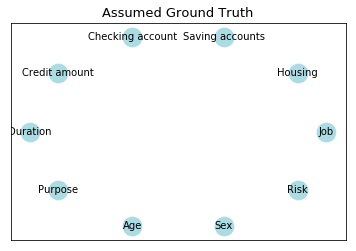

Creating the sensitive dictionary...

Analizing Sex ...

0.0 is discriminated: 0.09400214287276143
- DP: 156 · Expected: 172 · To be added: 16
- DN: 93 · Expected: 77 · To be removed: 16

1.0 is privileged: -0.09400214287276143
- PP: 397 · Expected: 381 · To be removed: 16
- PN: 154 · Expected: 170 · To be added: 16

Analizing Age ...

0.0 is discriminated: 0.19888402539532324
- DP: 84 · Expected: 109 · To be added: 25
- DN: 74 · Expected: 49 · To be removed: 25

1.0 is privileged: -0.19888402539532324
- PP: 469 · Expected: 444 · To be removed: 25
- PN: 173 · Expected: 198 · To be added: 25

Removing records...

Records removed: 66

Current length of dataset:  734
Current k-anonymity:  19


,Sex,Age,Housing,Count
0,0.0,0.0,0.0,35
1,0.0,0.0,1.0,45
2,0.0,1.0,0.0,115
3,0.0,1.0,1.0,26
4,1.0,0.0,0.0,34
5,1.0,0.0,1.0,19
6,1.0,1.0,0.0,410
7,1.0,1.0,1.0,50


 
Creating hybrid constraints...

New hybrid constraints created: Counter({((9, 1.0), (8, 1.0), (7, 0.0), (1, 1.0)): 8})
Total number of constraints: 5 

((9, 1.0), (8, 1.0), (7, 0.0), (1, 1.0)) 8
gen	nevals	min        	avg     
0  	150   	0.000845658	0.041993
1  	92    	0.000377049	0.0421335
2  	81    	0.000377049	0.0421879
3  	88    	8.397e-05  	0.0416222
4  	84    	8.397e-05  	0.0418993
5  	88    	4.57274e-06	0.0419403
6  	74    	4.57274e-06	0.040963 
7  	92    	4.57274e-06	0.0409272
8  	87    	4.57274e-06	0.0416787
9  	95    	4.57274e-06	0.0425445
10 	88    	4.57274e-06	0.0423479
11 	92    	4.57274e-06	0.0431071
12 	81    	4.51397e-06	0.0441926
13 	101   	4.51397e-06	0.04375  
14 	89    	4.51397e-06	0.0433329
15 	82    	4.51397e-06	0.0439956
16 	79    	4.51397e-06	0.0435661
17 	83    	4.51397e-06	0.043086 
18 	73    	4.51397e-06	0.0430578
19 	74    	4.51397e-06	0.043219 
20 	83    	4.51397e-06	0.0427801
21 	78    	4.51397e-06	0.0428013
22 	80    	4.51397e-06	0.0424357
23 	94    	4.

<Figure size 432x288 with 0 Axes>

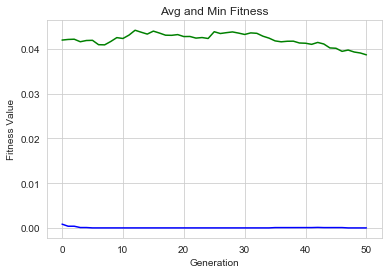

((9, 0), (8, 1.0), (7, 1.0)) 29
gen	nevals	min       	avg      
0  	150   	0.00130876	0.0564007
1  	93    	0.00130876	0.0559563
2  	94    	0.00141147	0.0561316
3  	81    	0.00141147	0.0557313
4  	92    	5.78909e-06	0.0564759
5  	89    	5.78909e-06	0.0558597
6  	90    	5.78909e-06	0.0549425
7  	91    	5.78909e-06	0.0554412
8  	83    	5.78909e-06	0.0540534
9  	97    	5.78909e-06	0.0541031
10 	97    	5.78909e-06	0.0538175
11 	77    	5.78909e-06	0.0537259
12 	85    	0.000114032	0.0532345
13 	93    	0.000114032	0.0534615
14 	88    	0.000618227	0.0546146
15 	101   	5.78909e-06	0.0552589
16 	82    	5.78909e-06	0.0556219
17 	93    	5.78909e-06	0.0555627
18 	85    	5.78909e-06	0.0554283
19 	86    	0.000290403	0.0557468
20 	89    	0.000290403	0.0559297
21 	104   	5.78909e-06	0.0554192
22 	85    	5.78909e-06	0.0554417
23 	92    	5.78909e-06	0.0551256
24 	97    	5.78909e-06	0.0549515
25 	69    	5.78909e-06	0.055493 
26 	87    	5.78909e-06	0.055625 
27 	83    	5.78909e-06	0.055252 
28 	86    	5.789

<Figure size 432x288 with 0 Axes>

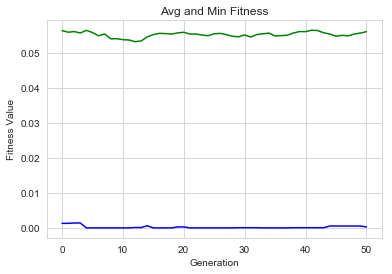

((9, 0), (8, 0.0), (7, 1.0)) 12
gen	nevals	min       	avg      
0  	150   	0.00431455	0.0739227
1  	86    	0.00431455	0.0746608
2  	89    	0.00934633	0.0745128
3  	86    	0.00934633	0.0741977
4  	77    	0.00934633	0.0743022
5  	80    	0.00876775	0.0744298
6  	91    	0.000342512	0.0745808
7  	74    	0.000567349	0.0746515
8  	104   	0.000342512	0.076544 
9  	93    	0.000342512	0.075355 
10 	92    	0.000342512	0.0751727
11 	89    	0.000342512	0.0747409
12 	94    	0.000342512	0.0752583
13 	102   	0.000342512	0.0744776
14 	89    	0.000342512	0.0750518
15 	83    	0.000342512	0.0751528
16 	81    	0.000342512	0.0748234
17 	83    	0.000289308	0.0747127
18 	94    	0.0011126  	0.0747911
19 	90    	0.0011126  	0.0752667
20 	77    	0.000404111	0.0750339
21 	95    	0.000299521	0.075954 
22 	74    	1.50015e-05	0.076796 
23 	99    	1.50015e-05	0.0762364
24 	75    	1.50015e-05	0.0756005
25 	106   	6.18887e-05	0.0750505
26 	76    	1.50015e-05	0.074687 
27 	84    	1.50015e-05	0.0745284
28 	85    	1.50015

<Figure size 432x288 with 0 Axes>

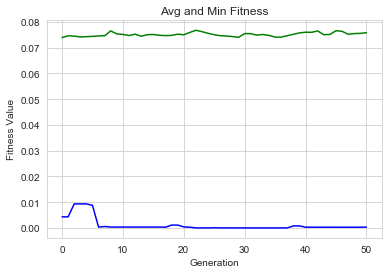

((9, 1), (8, 1.0), (7, 0.0)) 1
gen	nevals	min       	avg      
0  	150   	0.00123865	0.0540651
1  	84    	0.0013215 	0.0548026
2  	90    	0.0013215 	0.0546209
3  	85    	0.0013215 	0.0550681
4  	87    	0.00211191	0.0551333
5  	65    	0.00211191	0.0545814
6  	84    	0.00258168	0.0553712
7  	84    	0.00151788	0.0556176
8  	95    	0.00148642	0.0558179
9  	74    	0.00148642	0.0550954
10 	90    	0.00132976	0.0552654
11 	90    	0.000709868	0.0552639
12 	97    	0.000709868	0.0558369
13 	85    	0.000709868	0.0554917
14 	91    	0.000709868	0.0553   
15 	72    	0.000709868	0.0546577
16 	87    	0.000709868	0.0552961
17 	82    	0.000709868	0.0546159
18 	103   	0.000818702	0.0542201
19 	83    	0.000818702	0.0545919
20 	88    	0.000818702	0.0542952
21 	88    	0.000818702	0.0547545
22 	90    	0.000788115	0.0548793
23 	93    	0.000788115	0.0548112
24 	81    	0.000788115	0.0548847
25 	72    	0.000788115	0.0544018
26 	78    	0.00106519 	0.0538508
27 	93    	0.00106519 	0.0548863
28 	88    	0.00112562 	0

<Figure size 432x288 with 0 Axes>

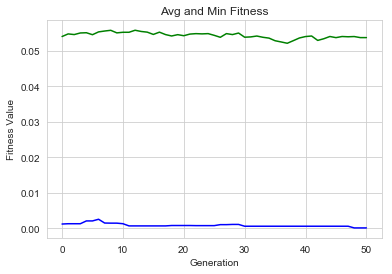

((9, 1), (8, 0.0), (7, 0.0)) 16
gen	nevals	min       	avg     
0  	150   	0.00961257	0.123102
1  	69    	0.00961257	0.121928
2  	89    	0.00356951	0.121794
3  	98    	0.00356951	0.12176 
4  	81    	0.00356951	0.122473
5  	84    	0.00356951	0.121968
6  	86    	0.00356951	0.122266
7  	86    	9.23813e-05	0.122774
8  	98    	9.23813e-05	0.122191
9  	85    	2.52271e-05	0.121934
10 	87    	0.00137765 	0.119841
11 	87    	0.00356951 	0.119058
12 	83    	0.00356951 	0.119083
13 	85    	0.00356951 	0.118891
14 	89    	0.00216546 	0.118194
15 	77    	0.00297608 	0.11886 
16 	77    	0.00322915 	0.119395
17 	94    	0.00806315 	0.119656
18 	84    	0.00568262 	0.11878 
19 	86    	0.00563447 	0.119062
20 	89    	0.00420151 	0.11996 
21 	79    	0.00420151 	0.119396
22 	97    	0.00420151 	0.118924
23 	81    	0.00420151 	0.11847 
24 	82    	0.00420151 	0.118206
25 	85    	0.00420151 	0.119008
26 	95    	0.00228869 	0.118735
27 	66    	0.00256758 	0.117726
28 	82    	0.00227363 	0.117055
29 	78    	0.002

<Figure size 432x288 with 0 Axes>

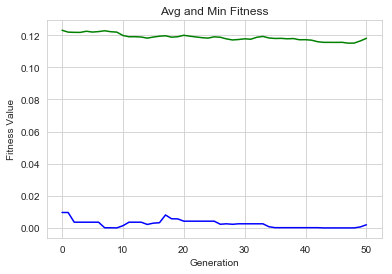

=== NEW DATASET ===

Analizing Sex ...

0.0 is discriminated: 0.0007070022376256535
- DP: 172 · Expected: 172 · To be added: 0
- DN: 77 · Expected: 77 · To be removed: 0

1.0 is privileged: -0.0007070022376256535
- PP: 381 · Expected: 381 · To be removed: 0
- PN: 170 · Expected: 170 · To be added: 0

Analizing Age ...

0.0 is discriminated: 0.0017153673252099377
- DP: 109 · Expected: 109 · To be added: 0
- DN: 49 · Expected: 49 · To be removed: 0

1.0 is privileged: -0.0017153673252099377
- PP: 444 · Expected: 444 · To be removed: 0
- PN: 198 · Expected: 198 · To be added: 0

OG dataset length: 800
Records generated: 66
New dataset length: 800
K-anonymity of the dataset: 26
Time: 7.828776597976685


In [38]:
df_fair, df_genetic = main(german, sensitive_attributes, class_name, #<- must be included
                           causal_reg, causal_class, #<- causal relations
                           discrete_attributes, values_in_dataset_attributes, #<- how to handle the various features
                          'Distance', 'Fixed', #<- fitness mode, datatased values mode
                           quasi_identifiers,  #<- quasi-identifiers must be inclued 
                           continuous_QI, categorical_QI, #<- optional QI to be generaliez first 
                           k_exp, eps) #<- expected k-anonymity and percentage of maximum number of synthetic records w.r.t the whole dataset 